In [25]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


### 1. Import Dependencies

In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn imports
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Class imbalance handling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

### 2. Load Engineered Features

In [27]:
# Load data from feature engineering notebook
df = pd.read_csv(r'D:\MY\Personal Projects\Zuu-Crew Projects\Building Production Ready ML Systems\Advance Telco Customer Churn Prediction\notebooks\artifacts\processed\telco_features_engineered.csv')
print(f"Dataset loaded: {df.shape}")
print(f"Target distribution:")
print(df['Churn'].value_counts())
print(f"Churn rate: {(df['Churn'] == 'Yes').mean()*100:.1f}%")
df.head()

Dataset loaded: (7043, 31)
Target distribution:
Churn
No     5174
Yes    1869
Name: count, dtype: int64
Churn rate: 26.5%


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group,tenure_category,service_adoption_score,avg_charges_per_service,payment_reliability_score,customer_value_segment,has_streaming,fiber_streaming_combo,senior_with_support,family_customer
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.8500,29.8500,No,0-12,New,2,14.9250,3,Low_Value_New,0,0,0,1
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.9500,1889.5000,No,25-36,Established,4,14.2375,4,Medium_Value,0,0,0,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.8500,108.1500,Yes,0-12,New,4,13.4625,4,Medium_Value,0,0,0,0
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.3000,1840.7500,No,37-48,Loyal,4,10.5750,5,Medium_Value,0,0,0,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.7000,151.6500,Yes,0-12,New,3,23.5667,3,Medium_Value,0,0,0,0


In [28]:
# Check for missing values
missing_values = df.isnull().sum().sum()
print(f"Total missing values: {missing_values}")

if missing_values > 0:
    print("Missing values by column:")
    print(df.isnull().sum()[df.isnull().sum() > 0])
else:
    print("✅ No missing values found!")

Total missing values: 11
Missing values by column:
tenure_group    11
dtype: int64


### 3. Prepare Features for Modeling

In [29]:
# Separate features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print(f"\nTarget encoding: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")

Feature matrix shape: (7043, 30)
Target vector shape: (7043,)

Target encoding: {'No': np.int64(0), 'Yes': np.int64(1)}


In [30]:
# Identify feature types for preprocessing
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical features ({len(numerical_features)}): {numerical_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")

# Check unique values in categorical features
print("\nCategorical feature cardinality:")
for feature in categorical_features:
    unique_count = X[feature].nunique()
    print(f"{feature:25s}: {unique_count:3d} unique values")

Numerical features (11): ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'service_adoption_score', 'avg_charges_per_service', 'payment_reliability_score', 'has_streaming', 'fiber_streaming_combo', 'senior_with_support', 'family_customer']
Categorical features (19): ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'tenure_group', 'tenure_category', 'customer_value_segment']

Categorical feature cardinality:
customerID               : 7043 unique values
gender                   :   2 unique values
Partner                  :   2 unique values
Dependents               :   2 unique values
PhoneService             :   2 unique values
MultipleLines            :   3 unique values
InternetService          :   3 unique values
OnlineSecurity           :   3 unique values
OnlineBack

### 4. Create Preprocessing Pipeline

In [31]:
# Create preprocessing pipelines for different feature types
from sklearn.impute import SimpleImputer

# Numerical preprocessing: imputation + scaling
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical preprocessing: imputation + one-hot encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

print("Preprocessing pipeline created:")
print(f"- Numerical features: Median imputation + Standard scaling")
print(f"- Categorical features: Constant imputation + One-hot encoding")

Preprocessing pipeline created:
- Numerical features: Median imputation + Standard scaling
- Categorical features: Constant imputation + One-hot encoding


### 5. Train-Test Split with Stratification

In [32]:
# Stratified train-test split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")

# Check class distribution in splits
train_churn_rate = y_train.mean()
test_churn_rate = y_test.mean()

print(f"\nClass distribution:")
print(f"Training set churn rate: {train_churn_rate:.3f}")
print(f"Test set churn rate: {test_churn_rate:.3f}")
print(f"Difference: {abs(train_churn_rate - test_churn_rate):.3f} (should be small)")

Training set: 5,634 samples
Test set: 1,409 samples

Class distribution:
Training set churn rate: 0.265
Test set churn rate: 0.265
Difference: 0.000 (should be small)


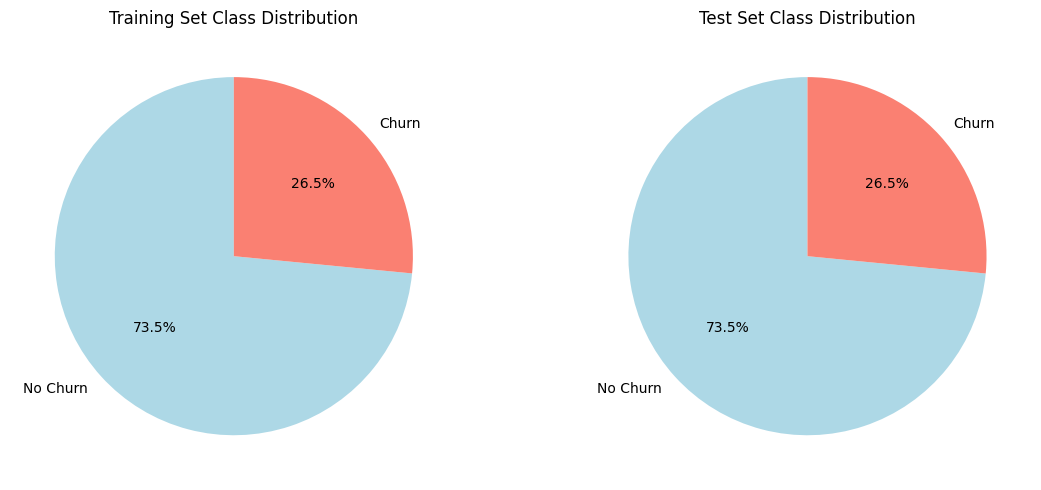

In [33]:
# Visualize class distribution in train/test splits
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Training set distribution
train_counts = pd.Series(y_train).value_counts().sort_index()
train_labels = ['No Churn', 'Churn']
axes[0].pie(train_counts.values, labels=train_labels, autopct='%1.1f%%', 
           colors=['lightblue', 'salmon'], startangle=90)
axes[0].set_title('Training Set Class Distribution')

# Test set distribution
test_counts = pd.Series(y_test).value_counts().sort_index()
axes[1].pie(test_counts.values, labels=train_labels, autopct='%1.1f%%', 
           colors=['lightblue', 'salmon'], startangle=90)
axes[1].set_title('Test Set Class Distribution')

plt.tight_layout()
plt.show()

### 6. Baseline Model - Logistic Regression

In [34]:
# Create baseline logistic regression model
baseline_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Fit the model
print("Training baseline logistic regression model...")
baseline_model.fit(X_train, y_train)
print("✅ Model training completed!")

Training baseline logistic regression model...
✅ Model training completed!


In [35]:
# Make predictions
y_train_pred = baseline_model.predict(X_train)
y_test_pred = baseline_model.predict(X_test)
y_train_pred_proba = baseline_model.predict_proba(X_train)[:, 1]
y_test_pred_proba = baseline_model.predict_proba(X_test)[:, 1]

# Calculate metrics
def calculate_metrics(y_true, y_pred, y_pred_proba):
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'roc_auc': roc_auc_score(y_true, y_pred_proba)
    }
    return metrics

# Baseline model performance
train_metrics = calculate_metrics(y_train, y_train_pred, y_train_pred_proba)
test_metrics = calculate_metrics(y_test, y_test_pred, y_test_pred_proba)

print("BASELINE MODEL PERFORMANCE (Logistic Regression)")
print("=" * 55)
print(f"{'Metric':<12} {'Training':<12} {'Test':<12} {'Difference':<12}")
print("-" * 55)
for metric in train_metrics.keys():
    train_val = train_metrics[metric]
    test_val = test_metrics[metric]
    diff = train_val - test_val
    print(f"{metric.upper():<12} {train_val:<12.4f} {test_val:<12.4f} {diff:<12.4f}")

BASELINE MODEL PERFORMANCE (Logistic Regression)
Metric       Training     Test         Difference  
-------------------------------------------------------
ACCURACY     0.8846       0.8027       0.0819      
PRECISION    0.8460       0.6579       0.1881      
RECALL       0.6910       0.5348       0.1562      
F1           0.7607       0.5900       0.1707      
ROC_AUC      0.9370       0.8427       0.0942      


### 7. Decision Tree Model

In [36]:
# Create decision tree model
tree_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_split=20))
])

# Fit the model
print("Training decision tree model...")
tree_model.fit(X_train, y_train)
print("✅ Model training completed!")

Training decision tree model...
✅ Model training completed!


In [37]:
# Make predictions
y_train_pred_tree = tree_model.predict(X_train)
y_test_pred_tree = tree_model.predict(X_test)
y_train_pred_proba_tree = tree_model.predict_proba(X_train)[:, 1]
y_test_pred_proba_tree = tree_model.predict_proba(X_test)[:, 1]

# Calculate metrics
train_metrics_tree = calculate_metrics(y_train, y_train_pred_tree, y_train_pred_proba_tree)
test_metrics_tree = calculate_metrics(y_test, y_test_pred_tree, y_test_pred_proba_tree)

print("DECISION TREE MODEL PERFORMANCE")
print("=" * 45)
print(f"{'Metric':<12} {'Training':<12} {'Test':<12} {'Difference':<12}")
print("-" * 45)
for metric in train_metrics_tree.keys():
    train_val = train_metrics_tree[metric]
    test_val = test_metrics_tree[metric]
    diff = train_val - test_val
    print(f"{metric.upper():<12} {train_val:<12.4f} {test_val:<12.4f} {diff:<12.4f}")

DECISION TREE MODEL PERFORMANCE
Metric       Training     Test         Difference  
---------------------------------------------
ACCURACY     0.8655       0.7828       0.0826      
PRECISION    0.8068       0.6141       0.1927      
RECALL       0.6482       0.4893       0.1589      
F1           0.7188       0.5446       0.1742      
ROC_AUC      0.9207       0.7857       0.1350      


### 8. Cross-Validation for Model Comparison

In [38]:
# Cross-validation setup
cv_folds = 5
cv_strategy = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

# Models to evaluate
models = {
    'Logistic Regression': baseline_model,
    'Decision Tree': tree_model
}

# Scoring metrics for cross-validation
scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

print("CROSS-VALIDATION RESULTS")
print("=" * 50)

cv_results = {}
for model_name, model in models.items():
    print(f"\n{model_name}:")
    cv_results[model_name] = {}
    
    for metric in scoring_metrics:
        scores = cross_val_score(model, X_train, y_train, cv=cv_strategy, 
                               scoring=metric, n_jobs=-1)
        cv_results[model_name][metric] = {
            'mean': scores.mean(),
            'std': scores.std(),
            'scores': scores
        }
        print(f"  {metric.upper():<12}: {scores.mean():.4f} (+/- {scores.std()*2:.4f})")

CROSS-VALIDATION RESULTS

Logistic Regression:
  ACCURACY    : 0.8097 (+/- 0.0247)
  PRECISION   : 0.6765 (+/- 0.0561)
  RECALL      : 0.5418 (+/- 0.0718)
  F1          : 0.6014 (+/- 0.0617)
  ROC_AUC     : 0.8479 (+/- 0.0220)

Decision Tree:
  ACCURACY    : 0.7762 (+/- 0.0293)
  PRECISION   : 0.5928 (+/- 0.0649)
  RECALL      : 0.5003 (+/- 0.0812)
  F1          : 0.5422 (+/- 0.0678)
  ROC_AUC     : 0.7787 (+/- 0.0363)


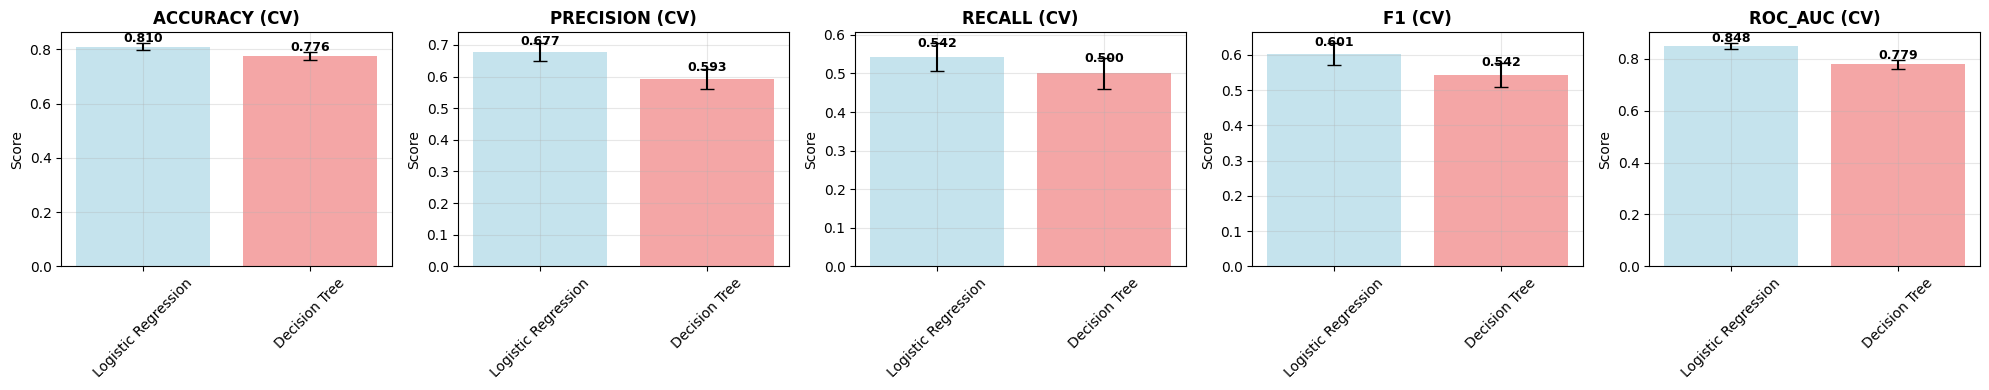

In [39]:
# Visualize cross-validation results
fig, axes = plt.subplots(1, len(scoring_metrics), figsize=(20, 4))

for i, metric in enumerate(scoring_metrics):
    model_names = list(cv_results.keys())
    means = [cv_results[model][metric]['mean'] for model in model_names]
    stds = [cv_results[model][metric]['std'] for model in model_names]
    
    bars = axes[i].bar(model_names, means, yerr=stds, capsize=5, 
                      color=['lightblue', 'lightcoral'], alpha=0.7)
    axes[i].set_title(f'{metric.upper()} (CV)', fontweight='bold')
    axes[i].set_ylabel('Score')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, mean in zip(bars, means):
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2., height + stds[bars.index(bar)]/2,
                    f'{mean:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

### 9. Handle Class Imbalance with SMOTE

In [40]:
# Create models with SMOTE for class imbalance
baseline_smote = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

tree_smote = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_split=20))
])

print("Training models with SMOTE for class imbalance handling...")

# Fit models with SMOTE
baseline_smote.fit(X_train, y_train)
tree_smote.fit(X_train, y_train)

print("✅ SMOTE models training completed!")

Training models with SMOTE for class imbalance handling...
✅ SMOTE models training completed!


In [41]:
# Evaluate SMOTE models
models_smote = {
    'Logistic Regression + SMOTE': baseline_smote,
    'Decision Tree + SMOTE': tree_smote
}

print("SMOTE MODELS CROSS-VALIDATION RESULTS")
print("=" * 55)

cv_results_smote = {}
for model_name, model in models_smote.items():
    print(f"\n{model_name}:")
    cv_results_smote[model_name] = {}
    
    for metric in scoring_metrics:
        scores = cross_val_score(model, X_train, y_train, cv=cv_strategy, 
                               scoring=metric, n_jobs=-1)
        cv_results_smote[model_name][metric] = {
            'mean': scores.mean(),
            'std': scores.std(),
            'scores': scores
        }
        print(f"  {metric.upper():<12}: {scores.mean():.4f} (+/- {scores.std()*2:.4f})")

SMOTE MODELS CROSS-VALIDATION RESULTS

Logistic Regression + SMOTE:
  ACCURACY    : 0.7796 (+/- 0.0257)
  PRECISION   : 0.5652 (+/- 0.0376)
  RECALL      : 0.7331 (+/- 0.0559)
  F1          : 0.6383 (+/- 0.0435)
  ROC_AUC     : 0.8470 (+/- 0.0225)

Decision Tree + SMOTE:
  ACCURACY    : 0.7659 (+/- 0.0437)
  PRECISION   : 0.5544 (+/- 0.0794)
  RECALL      : 0.6301 (+/- 0.0620)
  F1          : 0.5887 (+/- 0.0519)
  ROC_AUC     : 0.8100 (+/- 0.0272)


### 10. Model Comparison and Selection

In [42]:
# Combine all models for comparison
all_models = {**cv_results, **cv_results_smote}

# Create comparison DataFrame
comparison_data = []
for model_name in all_models.keys():
    model_data = {'Model': model_name}
    for metric in scoring_metrics:
        model_data[f'{metric}_mean'] = all_models[model_name][metric]['mean']
        model_data[f'{metric}_std'] = all_models[model_name][metric]['std']
    comparison_data.append(model_data)

comparison_df = pd.DataFrame(comparison_data)

print("MODEL COMPARISON SUMMARY")
print("=" * 80)
print(f"{'Model':<25} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1':<12} {'ROC-AUC':<12}")
print("-" * 80)

for _, row in comparison_df.iterrows():
    print(f"{row['Model']:<25} {row['accuracy_mean']:<12.4f} {row['precision_mean']:<12.4f} "
          f"{row['recall_mean']:<12.4f} {row['f1_mean']:<12.4f} {row['roc_auc_mean']:<12.4f}")

MODEL COMPARISON SUMMARY
Model                     Accuracy     Precision    Recall       F1           ROC-AUC     
--------------------------------------------------------------------------------
Logistic Regression       0.8097       0.6765       0.5418       0.6014       0.8479      
Decision Tree             0.7762       0.5928       0.5003       0.5422       0.7787      
Logistic Regression + SMOTE 0.7796       0.5652       0.7331       0.6383       0.8470      
Decision Tree + SMOTE     0.7659       0.5544       0.6301       0.5887       0.8100      


In [43]:
# Find best model for each metric
print("\nBEST MODELS BY METRIC:")
print("=" * 30)

for metric in scoring_metrics:
    metric_col = f'{metric}_mean'
    best_idx = comparison_df[metric_col].idxmax()
    best_model = comparison_df.loc[best_idx, 'Model']
    best_score = comparison_df.loc[best_idx, metric_col]
    print(f"{metric.upper():<12}: {best_model:<25} ({best_score:.4f})")

# Recommend best overall model (balanced F1 and ROC-AUC)
comparison_df['f1_roc_avg'] = (comparison_df['f1_mean'] + comparison_df['roc_auc_mean']) / 2
best_overall_idx = comparison_df['f1_roc_avg'].idxmax()
recommended_model = comparison_df.loc[best_overall_idx, 'Model']
recommended_score = comparison_df.loc[best_overall_idx, 'f1_roc_avg']

print(f"\n🏆 RECOMMENDED MODEL: {recommended_model}")
print(f"   Combined F1 + ROC-AUC Score: {recommended_score:.4f}")
print(f"   F1 Score: {comparison_df.loc[best_overall_idx, 'f1_mean']:.4f}")
print(f"   ROC-AUC Score: {comparison_df.loc[best_overall_idx, 'roc_auc_mean']:.4f}")


BEST MODELS BY METRIC:
ACCURACY    : Logistic Regression       (0.8097)
PRECISION   : Logistic Regression       (0.6765)
RECALL      : Logistic Regression + SMOTE (0.7331)
F1          : Logistic Regression + SMOTE (0.6383)
ROC_AUC     : Logistic Regression       (0.8479)

🏆 RECOMMENDED MODEL: Logistic Regression + SMOTE
   Combined F1 + ROC-AUC Score: 0.7426
   F1 Score: 0.6383
   ROC-AUC Score: 0.8470


### 11. Final Model Evaluation on Test Set

In [44]:
# Select best model and evaluate on test set
if 'SMOTE' in recommended_model:
    if 'Logistic' in recommended_model:
        best_model = baseline_smote
    else:
        best_model = tree_smote
else:
    if 'Logistic' in recommended_model:
        best_model = baseline_model
    else:
        best_model = tree_model

# Make final predictions on test set
y_test_pred_final = best_model.predict(X_test)
y_test_pred_proba_final = best_model.predict_proba(X_test)[:, 1]

# Calculate final metrics
final_metrics = calculate_metrics(y_test, y_test_pred_final, y_test_pred_proba_final)

print(f"FINAL MODEL PERFORMANCE ON TEST SET")
print(f"Model: {recommended_model}")
print("=" * 50)
for metric, value in final_metrics.items():
    print(f"{metric.upper():<12}: {value:.4f}")

FINAL MODEL PERFORMANCE ON TEST SET
Model: Logistic Regression + SMOTE
ACCURACY    : 0.7573
PRECISION   : 0.5320
RECALL      : 0.7112
F1          : 0.6087
ROC_AUC     : 0.8410


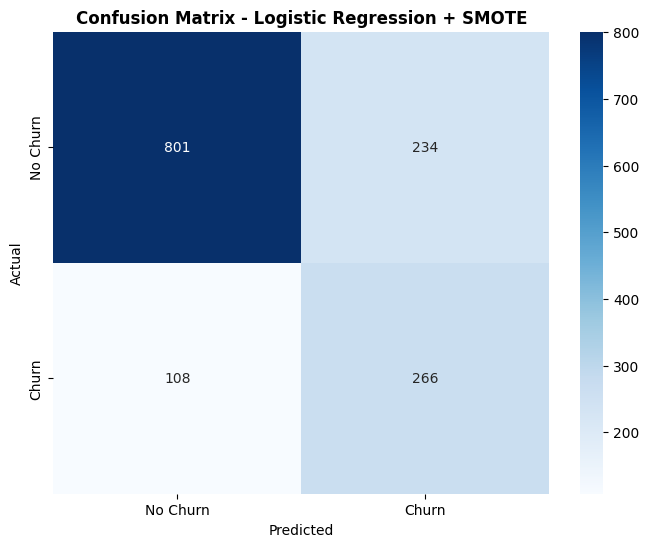

Confusion Matrix Breakdown:
True Negatives (Correctly predicted No Churn): 801
False Positives (Incorrectly predicted Churn): 234
False Negatives (Missed Churn): 108
True Positives (Correctly predicted Churn): 266


In [45]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Churn', 'Churn'], 
            yticklabels=['No Churn', 'Churn'])
plt.title(f'Confusion Matrix - {recommended_model}', fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print confusion matrix breakdown
tn, fp, fn, tp = cm.ravel()
print(f"Confusion Matrix Breakdown:")
print(f"True Negatives (Correctly predicted No Churn): {tn:,}")
print(f"False Positives (Incorrectly predicted Churn): {fp:,}")
print(f"False Negatives (Missed Churn): {fn:,}")
print(f"True Positives (Correctly predicted Churn): {tp:,}")

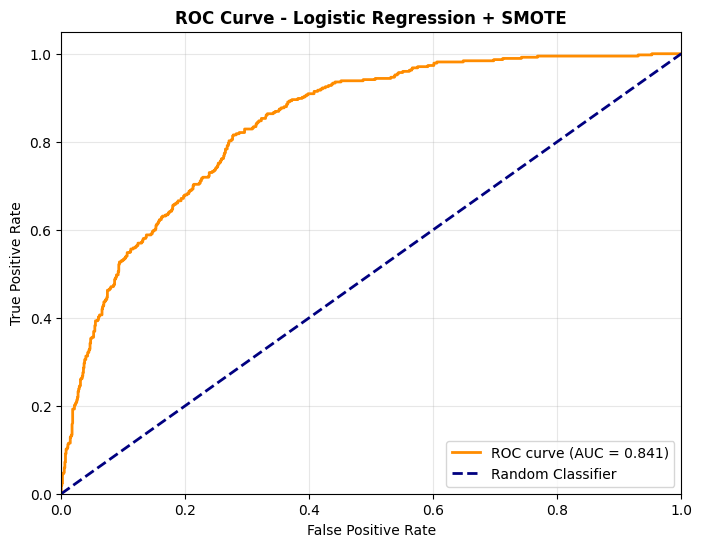

In [46]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba_final)
roc_auc = roc_auc_score(y_test, y_test_pred_proba_final)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {recommended_model}', fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

### 12. Save Models and Artifacts

In [47]:
# Ensure artifacts directory exists
os.makedirs('artifacts/models', exist_ok=True)
os.makedirs('artifacts/data', exist_ok=True)
os.makedirs('artifacts/reports', exist_ok=True)

# Save the best model (using relative paths)
model_filename = f'artifacts/models/{recommended_model.lower().replace(" ", "_").replace("+", "_")}_model.pkl'
joblib.dump(best_model, model_filename)
print(f"✅ Best model saved to: {model_filename}")

# Save label encoder
joblib.dump(label_encoder, 'artifacts/models/label_encoder.pkl')
print(f"✅ Label encoder saved to: artifacts/models/label_encoder.pkl")

# Save train/test splits for next notebooks
pd.DataFrame(X_train).to_csv('artifacts/data/X_train.csv', index=False)
pd.DataFrame(X_test).to_csv('artifacts/data/X_test.csv', index=False)
pd.DataFrame({'y_train': y_train}).to_csv('artifacts/data/y_train.csv', index=False)
pd.DataFrame({'y_test': y_test}).to_csv('artifacts/data/y_test.csv', index=False)

print(f"✅ Train/test splits saved to artifacts/data/")

✅ Best model saved to: artifacts/models/logistic_regression___smote_model.pkl
✅ Label encoder saved to: artifacts/models/label_encoder.pkl
✅ Train/test splits saved to artifacts/data/


### 13. Model Development Summary

In [48]:
print("MODEL DEVELOPMENT SUMMARY")
print("=" * 50)
print(f"\n📊 DATASET PREPARATION:")
print(f"   • Total samples: {df.shape[0]:,}")
print(f"   • Total features: {df.shape[1]-1}")
print(f"   • Numerical features: {len(numerical_features)}")
print(f"   • Categorical features: {len(categorical_features)}")
print(f"   • Class imbalance ratio: {(df['Churn']=='No').sum() / (df['Churn']=='Yes').sum():.1f}:1")

print(f"\n🏗️  MODELS DEVELOPED:")
print(f"   • Logistic Regression (baseline)")
print(f"   • Decision Tree")
print(f"   • Both models with SMOTE for imbalance handling")

print(f"\n📈 EVALUATION APPROACH:")
print(f"   • {cv_folds}-Fold Stratified Cross-Validation")
print(f"   • Metrics: Accuracy, Precision, Recall, F1, ROC-AUC")
print(f"   • Focus on imbalanced data metrics (F1, ROC-AUC)")

print(f"\n🏆 BEST MODEL SELECTED:")
print(f"   • Model: {recommended_model}")
print(f"   • Test F1 Score: {final_metrics['f1']:.4f}")
print(f"   • Test ROC-AUC: {final_metrics['roc_auc']:.4f}")
print(f"   • Test Precision: {final_metrics['precision']:.4f}")
print(f"   • Test Recall: {final_metrics['recall']:.4f}")

print(f"\n💾 ARTIFACTS SAVED:")
print(f"   • Best model: {model_filename}")
print(f"   • Label encoder: artifacts/models/label_encoder.pkl")
print(f"   • Train/test splits: artifacts/data/")

print(f"\n🔄 NEXT STEPS:")
print(f"   1. Ensemble methods (Random Forest, XGBoost, CatBoost)")
print(f"   2. Hyperparameter tuning")
print(f"   3. Advanced evaluation metrics")
print(f"   4. Business impact analysis")

timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"\n⏰ Completed: {timestamp}")

MODEL DEVELOPMENT SUMMARY

📊 DATASET PREPARATION:
   • Total samples: 7,043
   • Total features: 30
   • Numerical features: 11
   • Categorical features: 19
   • Class imbalance ratio: 2.8:1

🏗️  MODELS DEVELOPED:
   • Logistic Regression (baseline)
   • Decision Tree
   • Both models with SMOTE for imbalance handling

📈 EVALUATION APPROACH:
   • 5-Fold Stratified Cross-Validation
   • Metrics: Accuracy, Precision, Recall, F1, ROC-AUC
   • Focus on imbalanced data metrics (F1, ROC-AUC)

🏆 BEST MODEL SELECTED:
   • Model: Logistic Regression + SMOTE
   • Test F1 Score: 0.6087
   • Test ROC-AUC: 0.8410
   • Test Precision: 0.5320
   • Test Recall: 0.7112

💾 ARTIFACTS SAVED:
   • Best model: artifacts/models/logistic_regression___smote_model.pkl
   • Label encoder: artifacts/models/label_encoder.pkl
   • Train/test splits: artifacts/data/

🔄 NEXT STEPS:
   1. Ensemble methods (Random Forest, XGBoost, CatBoost)
   2. Hyperparameter tuning
   3. Advanced evaluation metrics
   4. Business i